# モデル学習

## Library Import

In [53]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import gc
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [54]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../../input/'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
intermediate_path = '../../output/intermediate_file/'
model_path = '../../output/model/'
oof_path = '../../output/oof/'
fi_path = '../../output/fi/'

# スクリプトのバージョン指定
fe_ver = 1
training_ver = 1

today = dt.datetime.today().strftime("%Y%m%d")

## File Import

In [55]:
train_df = pd.read_csv(f'{intermediate_path}train_df_fe_v{fe_ver}.csv')

In [56]:
date_col = 'target_ym'
target_col = 'money_room'

## 使用特徴量の選択

In [57]:
fe_cols = train_df.columns.to_list()
fe_cols.remove(target_col)

#### カテゴリ型へ変更

In [58]:
reform_cols = [
    'reform_interior 1',
    'reform_interior 2',
    'reform_interior 3',
    'reform_interior 4',
    'reform_interior 5',
    'reform_interior 6',
    'reform_exterior 1',
    'reform_exterior 1 ',
    'reform_exterior 2',
    'reform_wet_area 1',
    'reform_wet_area 2',
    'reform_wet_area 3',
    'reform_wet_area 4',
    'reform_wet_area 5',
    'reform_wet_area 6'
]

In [59]:
tag_groups = {
    # 土地まわりのタグ
    'land_price': [
        c for c in train_df.columns
        if c.startswith('土地価格_')
    ],

    # 建物性能・構造
    'building_struct': [
        c for c in train_df.columns
        if c.startswith('建物構造・性能_')
    ],

    # 建物の給排水・インフラ設備
    'infra': [
        c for c in train_df.columns
        if c.startswith('建物設備（給排水・インフラ）_')
    ],

    # 立地プレミアム（タグ由来のもの）
    'location_premium': [
        c for c in train_df.columns
        if c.startswith('立地プレミアム_')
    ],

    # 環境プレミアム（タグ由来のもの）
    'environment': [
        c for c in train_df.columns
        if c.startswith('環境プレミアム_')
    ],

    # 専有部分設備
    'senyu': [
        c for c in train_df.columns
        if c.startswith('専有部分設備')
    ],

    # 用途・投資セグメント
    'sales_status': [
        c for c in train_df.columns
        if c.startswith('用途・投資セグメント_売買ステータス_')
    ],
    'certificate': [
        c for c in train_df.columns
        if c.startswith('用途・投資セグメント_不動産の証明書・性能評価_')
    ],
}

tag_cols = []

for _, cols in tag_groups.items():
    tag_cols += cols

In [60]:
cat_cols = ['building_category', 'Prefecture name', 'City/town/village name', 
            'land_toshi', 'land_area_kind', 'land_youto', 'building_land_chimoku',
            'land_road_cond', 'building_area_kind', 'access_zone'
] + reform_cols + tag_cols

train_df[cat_cols] = train_df[cat_cols].astype('category')

In [61]:
# すべての category 列のリスト
obj_cols = train_df.select_dtypes(['object']).columns.tolist()

train_df[obj_cols] = train_df[obj_cols].astype('category')

## モデルの学習

In [62]:
base_cols = fe_cols.copy()
low_cols = fe_cols.copy()

y_all = train_df[target_col].astype(float)
y_all_log = np.log(y_all)

In [63]:
LOW_PRICE_TH = 10_000_000  # 低価格の閾値（1,000万円）

# LightGBM のベースパラメータ（あなたの設定）
base_params = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "num_leaves": 100,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1
}

low_params = {
    "num_leaves": 64,
    "min_child_samples": 30,
}

fi_list_base = []
fi_list_low = []

In [64]:
def mape(y_true, y_pred):
    """MAPE計算（%ではなくratio）。"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.clip(y_true, 1e-6, None))


def predict_with_base_and_low(base_model, low_model,
                              X_base, X_low,
                              low_th_log=np.log(LOW_PRICE_TH)):
    """
    base_model / low_model の両方で予測し、
    base_model の予測が低価格帯のものは low_model の予測に差し替える。
    （logスケールで返す）
    """
    base_pred_log = base_model.predict(X_base)
    low_pred_log = low_model.predict(X_low)

    pred_log = base_pred_log.copy()
    low_mask = base_pred_log <= low_th_log
    pred_log[low_mask] = low_pred_log[low_mask]

    return pred_log


In [65]:
def parse_year(date_input):
    try:
        s = str(date_input)
        if len(s) < 4:
            return np.nan
        return int(s[:4])
    except:
        return np.nan
    
train_df['target_year'] = train_df['target_ym'].apply(parse_year)

In [66]:
year_col = "target_year"
mask_train_cv = train_df[year_col] <= 2021   # 2019–2021 → CV
mask_holdout = train_df[year_col] == 2022    # 2022 → 完全 hold-out

idx_cv = train_df.index[mask_train_cv]
idx_ho = train_df.index[mask_holdout]

X_cv_base = train_df.loc[idx_cv, base_cols]
X_cv_low  = train_df.loc[idx_cv, low_cols]
y_cv_log  = y_all_log.loc[idx_cv]
groups_cv = train_df.loc[idx_cv, "building_id"]

X_ho_base = train_df.loc[idx_ho, base_cols]
X_ho_low  = train_df.loc[idx_ho, low_cols]
y_ho      = y_all.loc[idx_ho]      # MAPEは元スケールで見る

print(f"CV 用データ: {len(X_cv_base)} 行")
print(f"2022 hold-out データ: {len(X_ho_base)} 行")

CV 用データ: 274358 行
2022 hold-out データ: 89566 行


In [67]:
# OOF 用配列（log）
oof_pred_log = np.full(len(train_df), np.nan, dtype=float)
# 2022 HO は fold ごとの予測を平均
ho_pred_log_accum = np.zeros(len(idx_ho), dtype=float)

gkf = GroupKFold(n_splits=5)

print("=== GroupKFold CV (2019–2021, group=building_id) ===")
for fold, (tr_idx_local, va_idx_local) in enumerate(gkf.split(X_cv_base, y_cv_log, groups_cv), 1):
    tr_idx = idx_cv[tr_idx_local]
    va_idx = idx_cv[va_idx_local]

    # -------------------------
    # base_model の学習
    # -------------------------
    X_tr_base = train_df.loc[tr_idx, base_cols]
    y_tr_log  = y_all_log.loc[tr_idx]

    base_model = lgb.LGBMRegressor(**base_params)
    base_model.fit(X_tr_base, y_tr_log)

    # -------------------------
    # low_model の学習（低価格帯だけ）
    # -------------------------
    mask_tr_low = (y_all.loc[tr_idx] <= LOW_PRICE_TH)
    tr_idx_low = tr_idx[mask_tr_low]

    X_tr_low = train_df.loc[tr_idx_low, low_cols]
    y_tr_low_log = y_all_log.loc[tr_idx_low]

    low_model = lgb.LGBMRegressor(**low_params)
    low_model.fit(X_tr_low, y_tr_low_log)

    # -------------------------
    # OOF 予測（2019–2021 の validation 部）
    # -------------------------
    X_va_base = train_df.loc[va_idx, base_cols]
    X_va_low  = train_df.loc[va_idx, low_cols]

    va_pred_log = predict_with_base_and_low(
        base_model, low_model,
        X_va_base, X_va_low
    )
    oof_pred_log[va_idx] = va_pred_log

    # -------------------------
    # 2022 hold-out 予測（foldごとに平均）
    # -------------------------
    ho_pred_log = predict_with_base_and_low(
        base_model, low_model,
        X_ho_base, X_ho_low
    )
    ho_pred_log_accum += ho_pred_log / gkf.n_splits

    # 参考：foldごとのスコア
    y_va = y_all.loc[va_idx]
    va_pred = np.exp(va_pred_log)
    fold_mape = mape(y_va, va_pred)
    print(f"Fold {fold}: val MAPE={fold_mape:.4f}")

        # ====== FI accumulate ======
    # base_model feature importance
    fi_base = pd.DataFrame({
        "feature": base_cols,
        "importance": base_model.booster_.feature_importance(importance_type="gain")
    })
    fi_base["fold"] = fold
    fi_list_base.append(fi_base)

    # low_model feature importance
    fi_low = pd.DataFrame({
        "feature": low_cols,
        "importance": low_model.booster_.feature_importance(importance_type="gain")
    })
    fi_low["fold"] = fold
    fi_list_low.append(fi_low)

=== GroupKFold CV (2019–2021, group=building_id) ===
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32958
[LightGBM] [Info] Number of data points in the train set: 219486, number of used features: 323
[LightGBM] [Info] Start training from score 16.854185
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categor

In [68]:
# OOF / HO スコア
oof_mask_valid = ~np.isnan(oof_pred_log)
y_oof = y_all.loc[oof_mask_valid]
oof_pred = np.exp(oof_pred_log[oof_mask_valid])
oof_mape = mape(y_oof, oof_pred)

ho_pred = np.exp(ho_pred_log_accum)
ho_mape = mape(y_ho, ho_pred)

print(f"OOF MAPE (2019–2021) : {oof_mape:.6f}")
print(f"2022 hold-out MAPE  : {ho_mape:.6f}")

OOF MAPE (2019–2021) : 0.162791
2022 hold-out MAPE  : 0.148869


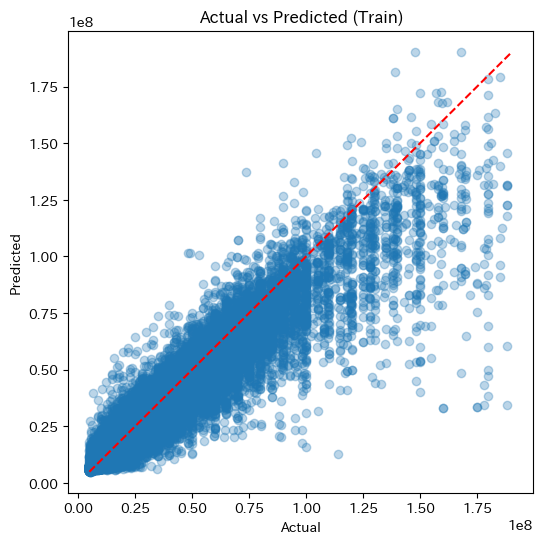

In [69]:
plt.figure(figsize=(6,6))
plt.scatter(y_ho, ho_pred, alpha=0.3)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train)")

# 45度線（完璧な予測ライン）
min_val = min(y_ho.min(), ho_pred.min())
max_val = max(y_ho.max(), ho_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 特徴量重要度

In [70]:
base_fi = (
    pd.concat(fi_list_base)
      .groupby("feature")["importance"]
      .mean()
      .reset_index()
      .sort_values("importance", ascending=False)
)

low_fi = (
    pd.concat(fi_list_low)
      .groupby("feature")["importance"]
      .mean()
      .reset_index()
      .sort_values("importance", ascending=False)
)

In [71]:
base_fi.to_csv(f'{fi_path}feature_importance_base.csv', index=False)
low_fi.to_csv(f'{fi_path}feature_importance_low.csv', index=False)

#### 特徴量重要度==0を削除

In [72]:
excluded_fe_base = base_fi.query("importance == 0")["feature"].tolist()
excluded_fe_low  = low_fi.query("importance == 0")["feature"].tolist()

print(f"[Base] Removed {len(excluded_fe_base)} features")
print(f"[Low]  Removed {len(excluded_fe_low)} features")

base_cols_filtered = [c for c in fe_cols if c not in excluded_fe_base]
low_cols_filtered = [c for c in fe_cols if c not in excluded_fe_low]

[Base] Removed 59 features
[Low]  Removed 129 features


#### OOFのMAPEを評価

In [73]:
# OOF / HO 用配列（log）
oof_pred_log_filtered = np.full(len(train_df), np.nan)
ho_pred_log_accum_filtered = np.zeros(len(idx_ho), dtype=float)

X_ho_base_filtered = train_df.loc[idx_ho, base_cols_filtered]
X_ho_low_filtered  = train_df.loc[idx_ho, low_cols_filtered]

gkf = GroupKFold(n_splits=5)

for fold, (tr_idx_local, va_idx_local) in enumerate(gkf.split(X_cv_base, y_cv_log, groups_cv), 1):
    tr_idx = idx_cv[tr_idx_local]
    va_idx = idx_cv[va_idx_local]

    # ==== 低価格帯インデックス（毎 fold 作り直し）====
    mask_tr_low = (y_all.loc[tr_idx] <= LOW_PRICE_TH)
    tr_idx_low = tr_idx[mask_tr_low]

    # ==== 新しい特徴量セット ====
    X_tr_base = train_df.loc[tr_idx, base_cols_filtered]
    X_tr_low  = train_df.loc[tr_idx_low, low_cols_filtered]
    X_va_base = train_df.loc[va_idx, base_cols_filtered]
    X_va_low  = train_df.loc[va_idx, low_cols_filtered]

    # ==== base model ====
    base_model_f = lgb.LGBMRegressor(**base_params)
    base_model_f.fit(X_tr_base, y_all_log[tr_idx])

    # ==== low model ====
    low_model_f = lgb.LGBMRegressor(**low_params)
    low_model_f.fit(X_tr_low, y_all_log[tr_idx_low])

    # ==== OOF prediction ====
    va_pred_log = predict_with_base_and_low(
        base_model_f, low_model_f,
        X_va_base, X_va_low
    )
    oof_pred_log_filtered[va_idx] = va_pred_log

    # ==== 2022 HO prediction（fold ごとに平均）====
    ho_pred_log = predict_with_base_and_low(
        base_model_f, low_model_f,
        X_ho_base_filtered, X_ho_low_filtered
    )
    ho_pred_log_accum_filtered += ho_pred_log / gkf.n_splits

# ===== OOF MAPE (filtered) =====
oof_pred_filtered = np.exp(oof_pred_log_filtered[oof_mask_valid])
oof_mape_filtered = mape(y_oof, oof_pred_filtered)
print(f"OOF MAPE (after removing FI=0) : {oof_mape_filtered:.6f}")

# ===== HO MAPE (filtered) =====
ho_pred_filtered = np.exp(ho_pred_log_accum_filtered)
ho_mape_filtered = mape(y_ho, ho_pred_filtered)
print(f"HO  MAPE (after removing FI=0) : {ho_mape_filtered:.6f}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32832
[LightGBM] [Info] Number of data points in the train set: 219486, number of used features: 287
[LightGBM] [Info] Start training from score 16.854185
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

In [78]:
train_result_df = train_df[fe_cols + [target_col]].copy()

# 初期化（全行 NaN）
train_result_df['oof_pred', 'ho_pred'] = np.nan

# 2022 年だけマスクを作る
mask_ho = (train_result_df['target_ym'].astype(str).str.startswith("2022"))

# OOF が存在する valid index に埋め込む
train_result_df.loc[oof_mask_valid, 'oof_pred'] = oof_pred_filtered
train_result_df.loc[mask_ho, 'ho_pred'] = ho_pred_filtered

print(train_result_df[['oof_pred', "ho_pred"]].head())
print(train_result_df[['oof_pred', "ho_pred"]].isna().mean())

train_result_df.to_csv(f'{oof_path}oof.csv', index=False)

       oof_pred  ho_pred
0  1.201000e+07      NaN
1  2.227172e+07      NaN
2  2.319121e+07      NaN
3  1.935627e+07      NaN
4  1.806100e+07      NaN
oof_pred    0.246112
ho_pred     0.753888
dtype: float64


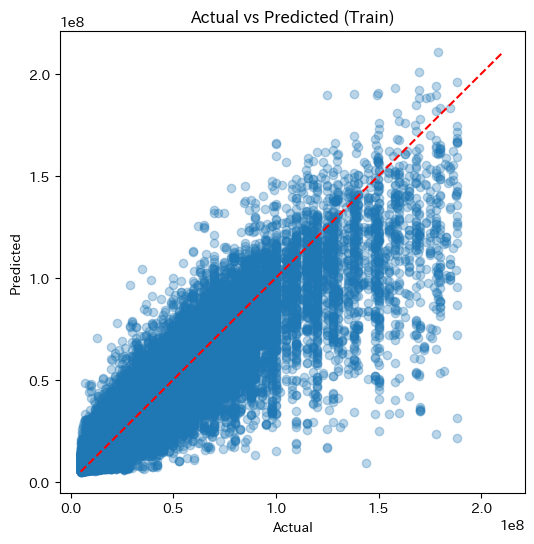

In [75]:
plt.figure(figsize=(6,6))
plt.scatter(y_oof, oof_pred_filtered, alpha=0.3)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train)")

# 45度線（完璧な予測ライン）
min_val = min(y_oof.min(), oof_pred_filtered.min())
max_val = max(y_oof.max(), oof_pred_filtered.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 最終モデル

In [41]:
# 特徴量重要度スコア0の特徴量を除外したモデルのOOFの方がMAPEよければ書き換え
base_cols = base_cols_filtered.copy()
low_cols = low_cols_filtered.copy()

idx_full = train_df.index

In [42]:
from sklearn.model_selection import KFold

def train_kfold_models(df, y_log, cols, params, n_splits=5):
    models = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, valid_idx in kf.split(df):
        X_tr = df.iloc[train_idx][cols]
        y_tr = y_log.iloc[train_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr, y_tr)
        models.append(model)

    return models


# -------------------------
# base model の 5fold
# -------------------------
X_full_base = train_df.loc[idx_full, base_cols]
y_full_log  = y_all_log.loc[idx_full]

base_models = train_kfold_models(
    X_full_base, y_full_log, base_cols, base_params
)

# -------------------------
# low model の 5fold
# -------------------------
mask_full_low = (y_all.loc[idx_full] <= LOW_PRICE_TH)
idx_full_low = idx_full[mask_full_low]

X_full_low_sub = train_df.loc[idx_full_low, low_cols]
y_full_low_log = y_all_log.loc[idx_full_low]

low_models = train_kfold_models(
    X_full_low_sub, y_full_low_log, low_cols, low_params
)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35327
[LightGBM] [Info] Number of data points in the train set: 291139, number of used features: 292
[LightGBM] [Info] Start training from score 16.872611
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

## モデルの出力

In [45]:
import pickle
base_dict = {
    "base_models": base_models,
    "base_cols": base_cols
}
low_dict = {
    "low_models": low_models,
    "low_cols": low_cols
}

with open(f'{model_path}base_models_v{training_ver}.pkl', "wb") as f:
    pickle.dump(base_dict, f)

with open(f'{model_path}low_models_v{training_ver}.pkl', "wb") as f:
    pickle.dump(low_dict, f)